In [1]:
from environments.SimplePlantSimulator import SimplePlantSimulator as PlantSimulator
import numpy as np
import matplotlib.pyplot as plt

In [2]:
env = PlantSimulator(num_plants=48, q=0.05, last_day=14, trace_decay_rate=0.99)
print(env.terminal_step)
print(env.steps_per_day, env.steps_per_night)

1007
72 72


#### Test different lighting policies

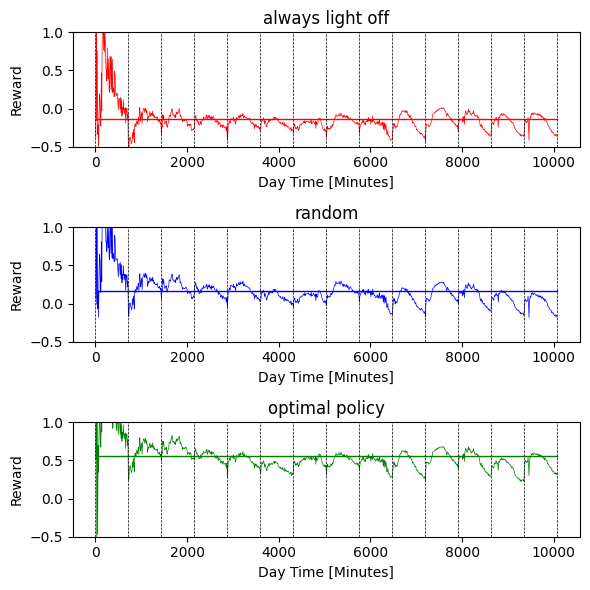

In [3]:
COLORS = ['r', 'b', 'g']
LABELS = ['always light off', 'random', 'optimal policy']
fig, ax = plt.subplots(3, 1, figsize=(6,6))

policy1 = np.zeros(env.terminal_step)
policy2 = np.random.choice([0, 1, 2, 3], env.terminal_step)
segment = int(env.steps_per_day/4)
policy3 = np.tile(np.hstack([np.ones(segment), 2*np.ones(segment*2), np.ones(segment)]), env.last_day)
policy = [policy1, policy2, policy3]

for i in range(3):
    env.start()
    R = []  # reward
    State = []
    pol = policy[i]
    for _ in range(env.terminal_step):
        reward, next_state, done, info = env.step(int(pol[_]))
        R.append(reward)
        State.append(env.current_state)
    
    # Plot reward history
    ax[i].plot(np.arange(1, len(R)+1)*env.interval/60, R, color=COLORS[i], linewidth=0.5)
    ax[i].plot(np.arange(1, len(R)+1)*env.interval/60, np.ones(len(R))*np.mean(R), color=COLORS[i], linewidth=1)
    ax[i].set_title(LABELS[i])
    ax[i].set_xlabel('Day Time [Minutes]')
    ax[i].set_ylabel('Reward')
    ax[i].set_ylim(-0.5,1)
    

for i in range(int(len(R)/env.steps_per_day)+2):
    ax[0].axvline(x = env.steps_per_day*i*env.interval/60, color='k', linestyle='--', linewidth=0.5)
    ax[1].axvline(x = env.steps_per_day*i*env.interval/60, color='k', linestyle='--', linewidth=0.5)
    ax[2].axvline(x = env.steps_per_day*i*env.interval/60, color='k', linestyle='--', linewidth=0.5)

fig.tight_layout()

(0.0, 1.0)

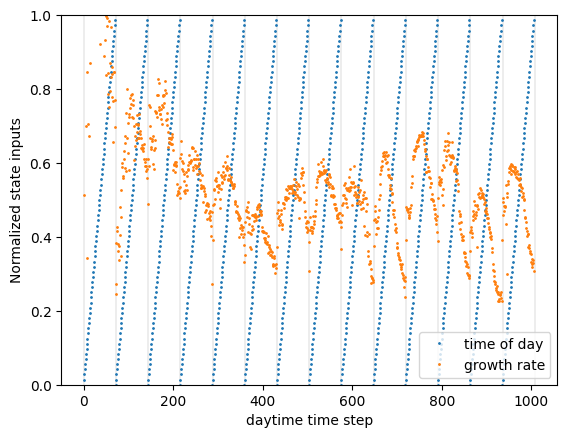

In [4]:
State = np.array(State)
for i in range(int(len(R)/env.steps_per_day)+2):
    plt.axvline(x = env.steps_per_day*i, color='k', linewidth=.1)
plt.plot(State[:,:], '.', markersize=2, label=['time of day','growth rate'])

plt.ylabel('Normalized state inputs')
plt.xlabel('daytime time step')
plt.legend()
plt.ylim([0,1])